In [236]:
#copyright joshuah.rainstar@gmail.com
from __future__ import annotations
import math
import typing

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Dict, Tuple


class Coop5(nn.Module):
    def __init__(self):
        super().__init__()

    @staticmethod
    def _softsign(x: torch.Tensor) -> torch.Tensor:
        return x / (1.0 + x.abs())

    @staticmethod
    def _zls(x: torch.Tensor) -> torch.Tensor:
        sp = F.softplus(x)
        sa = torch.sigmoid(0.5 * x)
        ba = sa * (1.0 - sa)
        return sp - 2.77258872223978123766 * ba  # 4*ln(2)

    @staticmethod
    def forward(R: torch.Tensor, C: torch.Tensor) -> torch.Tensor:
        # Similarity gating
        w = Coop5._zls(Coop5._softsign(R * C).sum(dim=-1, keepdim=True) / (2 * R.size(-1) ** 0.5))
        # RK2-style update
        k1 = w * (C - R)
        k2 = w * (C - (R + 0.5 * k1))
        return R + 0.25 * (k1 - k2)
        
    '''#may offer better effect, but more costly
    @staticmethod
    def forward(R: torch.Tensor, C: torch.Tensor) -> torch.Tensor:
        # Similarity gating
        w = Coop5._zls(Coop5._softsign(R * C).sum(dim=-1, keepdim=True) / (2 * R.size(-1) ** 0.5))
        # RK2-style update
        k1 = w * (C - R)
        # Midpoint
        R_mid = R + 0.5 * k1
        w2 = Coop5._zls(Coop5._softsign(R_mid * C).sum(dim=-1, keepdim=True) / (2 * R.size(-1) ** 0.5))
        k2 = w2 * (C - R_mid)
        return R + 0.25 * (k1 + k2)
    '''


class DynMix(nn.Module):
    def __init__(self):
        super().__init__()
        self.coop = Coop5()

    def mix_list(self,xs):
        n = len(xs)
        stacked = torch.stack(xs, 0)
        total = stacked.sum(0)
        out = []
        for i in range(n):
            others_mean = (total - stacked[i]) / (n - 1)
            out.append(self.coop(stacked[i], others_mean))
        return out

    def forward(self, comps, loop_iters: int = 2):
        for _ in range(loop_iters):
            comps = self.mix_list(comps)
        return comps
        
class PhaseTap(nn.Module):
    """
    Phase-preserving vector shift with guarded Householder.
    x: (B,T,C) -> y: (B,T,C)
      - t < d:  y[:, t, :] = (1/(d - t)) * a
      - t >= d: y[:, t, :] = H(x_t)^T @ (x_t - x_{t-d})
    Guards:
      - near u_t ≈ a: skip reflection, use identity on v
      - near u_t ≈ -a: use fixed orthonormal b
      - near zero ||x_t||: skip reflection
    """
    def __init__(self, d: int, tau: float = 1e-6):  # ?1 tau
        super().__init__()
        assert isinstance(d, int) and d >= 1
        self.d = d
        self.tau = float(tau)

    @staticmethod
    def _norm(v: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
        return torch.linalg.vector_norm(v, dim=-1).clamp_min(eps)

    @staticmethod
    def _safe_unit(v: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
        n = torch.linalg.vector_norm(v, dim=-1, keepdim=True).clamp_min(eps)
        return v / n

    def _apply_householder_sym(self, a: torch.Tensor, u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
        """
        Apply H v with H a = u, H = I - 2 w w^T, symmetric so H^T = H.
        a,u,v: (..., C)
        Guards near a, near -a, and near zero u.
        """
        C = a.shape[-1]
        # masks
        dot = (a * u).sum(dim=-1, keepdim=True)                      # (...,1)
        near_pos = (dot > 1.0 - self.tau).squeeze(-1)                # (...)
        near_neg = (dot < -1.0 + self.tau).squeeze(-1)               # (...)
        near_zero_u = (torch.linalg.vector_norm(u, dim=-1) < self.tau)  # (...)

        y = v.clone()

        # general case mask
        gen = ~(near_pos | near_neg | near_zero_u)
        if gen.any():
            w = self._safe_unit(a[gen] - u[gen])
            wTv = (w * v[gen]).sum(dim=-1, keepdim=True)
            y[gen] = v[gen] - 2.0 * w * wTv

        # near -a: reflect across fixed b orthonormal to a
        if near_neg.any():
            if C == 1:
                y[near_neg] = -v[near_neg]
            else:
                b = torch.zeros_like(a[near_neg])
                b[..., 1] = 1.0
                bbT_v = (b * v[near_neg]).sum(dim=-1, keepdim=True)
                y[near_neg] = v[near_neg] - 2.0 * b * bbT_v

        # near +a or near zero u: identity on v
        # y[near_pos] and y[near_zero_u] already equal v by init

        return y

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3, "x must be (B,T,C)"
        B, T, C = x.shape
        device = x.device
        dtype = x.dtype

        y = torch.zeros_like(x)

        # anchor a = e0
        a = torch.zeros(B, 1, C, device=device, dtype=dtype)
        a[..., 0] = 1.0

        # early baseline
        if self.d > 0:
            t_idx = torch.arange(T, device=device)
            early_mask = t_idx < self.d
            if early_mask.any():
                denom = (self.d - t_idx[early_mask]).to(dtype=dtype)
                y[:, early_mask, :] = a.expand(B, early_mask.sum(), C) * denom.unsqueeze(0).reciprocal().unsqueeze(-1)

        if T <= self.d:
            return y

        # main region
        x_t  = x[:, self.d:, :]          # (B,T-d,C)
        x_tm = x[:, :-self.d, :]         # (B,T-d,C)
        u_t  = self._safe_unit(x_t)      # (B,T-d,C)

        a_bt = a.expand(B, x_t.shape[1], C)
        v    = x_t - x_tm

        if C == 1:
            y[:, self.d:, :] = v
            return y

        y[:, self.d:, :] = self._apply_householder_sym(a_bt, u_t, v)
        return y
        
class PhaseTransport(nn.Module):
    def __init__(self, d: int, tau: float = 1e-6):
        super().__init__()
        assert isinstance(d, int) and d >= 1
        self.d = d
        self.tau = float(tau)

    @staticmethod
    def _norm(v: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
        return torch.linalg.vector_norm(v, dim=-1).clamp_min(eps)

    @staticmethod
    def _safe_unit(v: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
        n = torch.linalg.vector_norm(v, dim=-1, keepdim=True).clamp_min(eps)
        return v / n

    @staticmethod
    def _orthonormal_perp(v: torch.Tensor) -> torch.Tensor:
        # v: (N, C) assumed nonzero
        N, C = v.shape
        idx = torch.argmin(torch.abs(v), dim=-1)      # pick coord with smallest magnitude
        e = torch.zeros_like(v)
        e.scatter_(1, idx.unsqueeze(1), 1.0)
        p = e - (e * v).sum(dim=-1, keepdim=True) * v # Gram-Schmidt
        p = p / PhaseTransport._norm(p).unsqueeze(-1)
        return p

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3, "x must be (B,T,C)"
        B, T, C = x.shape
        device, dtype = x.device, x.dtype
        y = torch.zeros_like(x)

        # early baseline with per-sequence direction, not a global axis
        if T > 0:
            ref_t = min(self.d, T - 1)
            u_ref = self._safe_unit(x[:, ref_t, :])  # (B, C)
            if self.d > 0:
                t_idx = torch.arange(T, device=device)
                early_mask = t_idx < self.d
                if early_mask.any():
                    denom = (self.d - t_idx[early_mask]).to(dtype=dtype)     # (Te,)
                    scales = (1.0 / denom).view(1, -1, 1)                    # (1, Te, 1)
                    y[:, early_mask, :] = u_ref.view(B, 1, C) * scales       # (B, Te, C)

        if T <= self.d:
            return y

        # main region t >= d
        xt  = x[:, self.d:, :]             # (B, T-d, C)
        xtm = x[:, :-self.d, :]            # (B, T-d, C)
        u   = self._safe_unit(xt)          # (B, T-d, C)
        v   = self._safe_unit(xtm)         # (B, T-d, C)
        w   = xt - xtm                      # (B, T-d, C)

        c = (u * v).sum(dim=-1, keepdim=True)          # (B, T-d, 1)
        # squeeze masks to (B, T-d)
        near_pos = (c > 1.0 - self.tau).squeeze(-1)
        near_neg = (c < -1.0 + self.tau).squeeze(-1)
        small_u  = (torch.linalg.vector_norm(xt,  dim=-1) < self.tau)
        small_v  = (torch.linalg.vector_norm(xtm, dim=-1) < self.tau)
        trivial  = near_pos | small_u | small_v

        y_main = w.clone()

        # general case
        gen = ~(trivial | near_neg)
        if gen.any():
            u_g = u[gen]                       # (N, C)
            v_g = v[gen]
            w_g = w[gen]
            c_g = c[gen].unsqueeze(-1)[:, 0, :]  # (N, 1) ensure 2D
            alpha = 1.0 / (1.0 + c_g)          # (N, 1)

            a = (v_g * w_g).sum(dim=-1, keepdim=True)  # v·w
            b = (u_g * w_g).sum(dim=-1, keepdim=True)  # u·w
            Kw  = u_g * a - v_g * b
            K2w = u_g * (a * c_g - b) + v_g * (b * c_g - a)
            y_main[gen] = w_g - Kw + alpha * K2w

        # antipodal 180 deg
        if near_neg.any():
            v_n = v[near_neg]                 # (N, C)
            w_n = w[near_neg]
            p   = self._orthonormal_perp(v_n) # (N, C)
            proj_v = (v_n * w_n).sum(dim=-1, keepdim=True) * v_n
            proj_p = (p   * w_n).sum(dim=-1, keepdim=True) * p
            y_main[near_neg] = w_n - 2.0 * proj_v - 2.0 * proj_p

        y[:, self.d:, :] = y_main
        return y
class Cell(nn.Module):
    def __init__(self, dim_in: int, hidden: int):
        super().__init__()
        self.fc1 = nn.Linear(dim_in, hidden, bias=False) #dont change, false intentional
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='selu') #dont change, selu intentional
        self.fc2 = nn.Linear(hidden, dim_in, bias=True)
        torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='selu') #dont change, selu intentional
        self.act = nn.Softplus()
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x))-1)   

class RecurrentMLP(nn.Module):
    def __init__(self, dim_in: int):
        super().__init__()
        self.k = 2 #can set to 3, but marginal gains
        self.hidden = dim_in*2 #if overfitting reduce to dim_in or even dim_in//2
        self.cells_a = nn.ModuleList([Cell(dim_in, self.hidden) for _ in range(self.k)])
    def forward(self, x):
        z = x
        for i in range(self.k):
            z = z + self.cells_a[i](z)
        return z
        

class BlockFast(nn.Module):
    def __init__(self, config,d):
        super().__init__()
        self.encodea  = RecurrentMLP(config.n_embd)
        self.encodeb  = RecurrentMLP(config.n_embd)
        self.encodec  = RecurrentMLP(config.n_embd)

        self.distance_encoder_learned = PhaseTransport(d)
        self.distance_measure_fixed = PhaseTap(d)
        self.mixer = DynMix()
    def forward(self, x):
        B,T,C= x.shape
        p = self.distance_encoder_learned(x)
        a =  self.encodea(p)
        q = self.distance_measure_fixed(x)
        b =  self.encodeb(q)
        s = p + q
        c = self.encodec(s)
        t = self.mixer([a,b,c])
        
        x = x + t[2]
        return x

        
@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 66 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_embd: int = 128
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        self.n_embd = config.n_embd

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            h = nn.ModuleList([BlockFast(config,1) for _ in range(config.n_layer)]),
        ))
       
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # tie weights
        self.lm_head.weight = self.transformer.wte.weight


    # ---------- forward ----------
    def forward(self, idx, targets=None, eprint=False):
        device = idx.device
        b, t = idx.size()
        x = self.transformer.wte(idx)
        for block in self.transformer.h:
            x= block(x)

        
        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=-1
            )
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None
        return logits, loss

In [231]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...


KeyboardInterrupt: 

In [237]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,#"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [238]:
# import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )


config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=6,
    n_embd=64,
    block_size=block_size
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

model = GPT(config)

model = model.to(device)



In [239]:
    total_params = sum(param.numel() for param in model.parameters())
    print(f"Total parameters: {total_params}")

Total parameters: 596352


In [240]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []
def train_epoch():
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

1907.2672119140625
855.0569458007812
563.7791748046875
433.9211120605469
354.4042053222656
287.825927734375
251.74143981933594
209.37950134277344
183.8666229248047
155.26016235351562
132.2980194091797
119.84599304199219
100.24019622802734
93.77685546875
78.68721008300781
70.41522216796875
59.93122482299805
51.766143798828125
49.58502197265625
43.31861114501953
40.768821716308594
35.653099060058594
34.99789047241211
31.908658981323242
31.079330444335938
27.70389747619629
27.357892990112305
24.37193489074707
23.69078254699707
22.518800735473633
21.920291900634766
22.062000274658203
19.064002990722656
19.817739486694336
19.24001693725586
17.96811866760254
16.61320686340332
15.512561798095703
15.861186027526855
16.269758224487305
14.764254570007324
14.212292671203613
13.932312965393066
14.078245162963867
11.852798461914062
12.29050350189209
11.681061744689941
11.85161304473877
10.41460132598877
10.792914390563965
10.477081298828125
9.91912841796875
10.528800010681152
9.649468421936035
9.19

KeyboardInterrupt: 

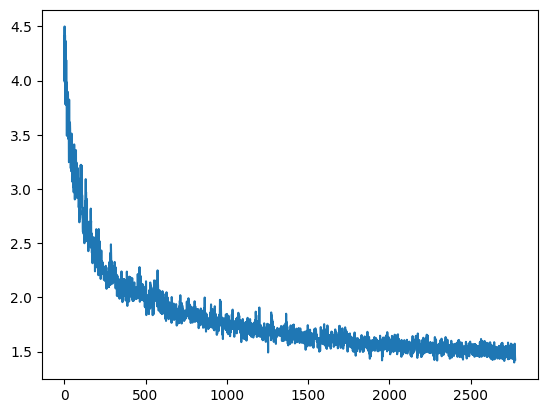

In [242]:
from matplotlib import pyplot as plt
plt.plot(losses[100:])
plt.show()

In [287]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UnigramModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # learnable logits for each vocab item, no context
        self.logits = nn.Parameter(torch.zeros(vocab_size))

    def forward(self, idx, targets=None):
        if idx.ndim == 3:
            B1, B2, T = idx.shape
            B = B1 * B2
            idx = idx.reshape(B, T)
            if targets is not None:
                targets = targets.reshape(B, T)
        elif idx.ndim == 2:
            B, T = idx.shape
        else:
            raise ValueError(f"Unexpected idx shape: {idx.shape}")
    
        logits = self.logits.expand(B, T, -1)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1),
                ignore_index=-1
            )
        return logits, loss


In [275]:
CEmodel = UnigramModel(vocab_size).to(device)

# evaluate on validation
for X, Y in val_loader:  # build a DataLoader for val_ids
    _, loss = CEmodel(X, targets=Y)
    print("CE (nats):", loss.item())
    print("BPC:", loss.item() / torch.log(torch.tensor(2.0)))
    print("PPL:", torch.exp(loss).item())
    break

CE (nats): 4.18965482711792
BPC: tensor(6.0444)
PPL: 66.00000762939453


In [243]:
import numpy as np
import torch
import torch.nn.functional as F

@torch.no_grad()
def eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=None):
    """
    Computes BPC and PPL on random contiguous slices.
    Assumes ?1 the loss returned by model(x, y) is mean NLL per token.
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    total_nll_nat = 0.0
    total_tokens = 0

    for _ in range(max_batches):
        if len(val_ids) <= block_size + 1:
            break

        start = np.random.randint(0, len(val_ids) - block_size - 1)
        x = torch.tensor(val_ids[start:start+block_size], dtype=torch.long, device=device)[None, :]
        y = torch.tensor(val_ids[start+1:start+block_size+1], dtype=torch.long, device=device)[None, :]

        # IMPORTANT: pass y so the model returns a sequence loss
        logits, loss = model(x, y)

        # If model doesn’t return loss for some reason, compute it safely
        if loss is None:
            # Handle both possible logits shapes
            if logits.dim() == 3 and logits.size(1) == x.size(1):
                # full sequence logits [B, T, V]
                B, T, V = logits.shape
                ce = F.cross_entropy(logits.view(-1, V), y.view(-1), reduction="mean")
                nll_nat = ce.item()
                tokens = T * B
            elif logits.dim() == 2:
                # last-step logits [B, V] -> only evaluate the last target
                ce = F.cross_entropy(logits, y[:, -1], reduction="mean")
                nll_nat = ce.item()
                tokens = logits.size(0)  # B tokens (here 1)
            else:
                raise ValueError(f"Unexpected logits shape: {tuple(logits.shape)}")
        else:
            # ?1 assume this is mean NLL per token (standard)
            nll_nat = float(loss.item())
            tokens = x.numel()  # B * T

        total_nll_nat += nll_nat * tokens
        total_tokens  += tokens

    if total_tokens == 0:
        return float("nan"), float("nan")

    avg_nll_nat = total_nll_nat / total_tokens
    bpc = avg_nll_nat / np.log(2.0)
    ppl = float(np.exp(avg_nll_nat))
    return bpc, ppl

bpc, ppl = eval_bits_per_char(model, val_ids, block_size=2048, max_batches=200, device=device)
print("BPC:", bpc, "Perplexity:", ppl)


BPC: 2.5387095979324203 Perplexity: 5.810690438693718


'''
Negative log-likelihood (NLL): The metric underneath both BPC and PPL is the average negative log probability assigned to the true next token. Lower NLL means the model is assigning higher probability to correct targets → better performance.

BPC = NLL in bits per token. Lower BPC means fewer bits are needed to encode the text, i.e. the model compresses language better. A perfect model would reach 0.0 BPC.

PPL = exp(NLL). It represents the "effective branching factor" (how many equally likely next tokens the model is as uncertain between). Lower perplexity means the model is more confident and accurate. A perfect model would reach 1.0 PPL.'
'''
#Models with <100k parameters usually collapse to gibberish or never beat 5-gram.
#BPC of NGRAM is ~3.5-4

In [251]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)

    
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=2048,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=2.0
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
Noit heaveim!
Fuueed York.

SO'Ennnn
w throves?
I had 'twe coz
Littlel, Pistfal.
Caszaavi!r jepruile By oBjto
Marry Vo;
Brodge'
forthep she they:
Sreeping-papes Bagniet us we:le majose:--
Do?...::Vw eved T MaCITHDD-bb--Cnigle- RI cyof in: dose words?

Gead unquot friendue, get in the emitikent
Yussec
Nieny onsmanuM,--GEop:
Weout refit cromCL-CI-Ca-Ca-popes flat.
Cutch,
'KKed:
Ilde mat; s
snownc paoceity? lotr'd nieststrayne. Ghurl; Apte-- chroke of Nadlouked;
Koccess: bubgay,
ilen asier
seen's-burt Valsain! fill'
TTlay,
As thul died conted Ve'ensur,
Aseg, demedteo hippiep?
An mygh?
Utca's;
As xNac absh, T
apmotinjur Cage?
I pruzes ad--
If every!
Elible. OkefO Ao a name A.
E promp sooarran DE onily! onvenll, Inige'?
O'd Keep HeMt Duke at-vivi' Qecat'.-feniul, naitiye them--
an
Of xhIrea, agahd--I is by o'cword?
Again'd usmefore, nuckut!!!!!!P!gefuk up; when PornA.

CUMBEABI:
Whose breatd.
Ience.--we. Wad;
Thvs:--MonaSe
Vo it
Tell us:
Que, your
Son

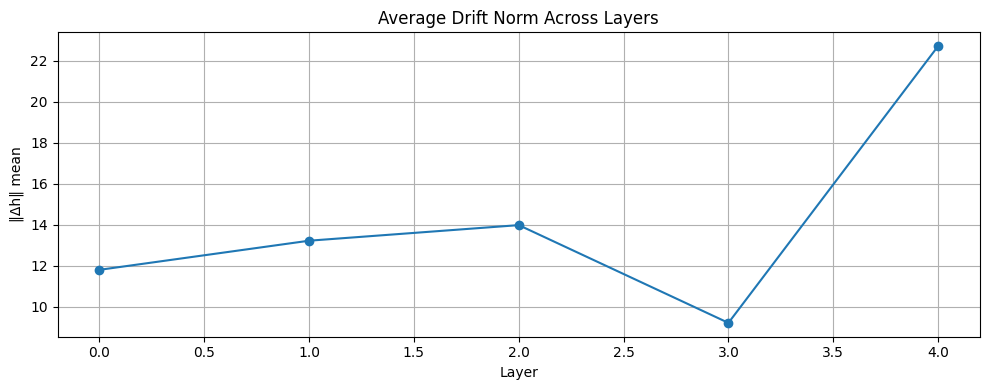

Jacobian rank (final token, projected): 63


In [245]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        embeddings = torch.cat([self.transformer.wte[i](idx)  for i in range(self.n_head)], dim=-1)
        embeddings = embeddings + pos_emb
        x = self.transformer.drop(embeddings)
        x_orig = x.clone()
        for stage in self.transformer.h:  # stages are ExplorerEngineerStage
          x = stage(x, x_orig)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss
'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # token + pos emb
    x = model.transformer.wte(tok)

    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb = model.transformer.wte(tok)
    emb = tok_emb

    def forward_emb(x):
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [246]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    x = model.transformer.wte(tok)

    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, tok_emb.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [247]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


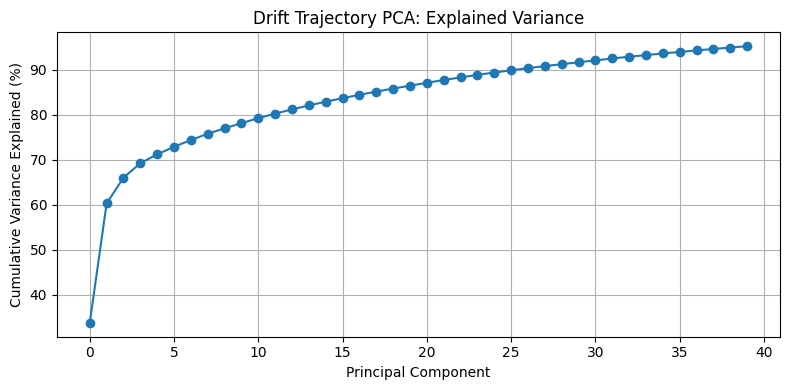

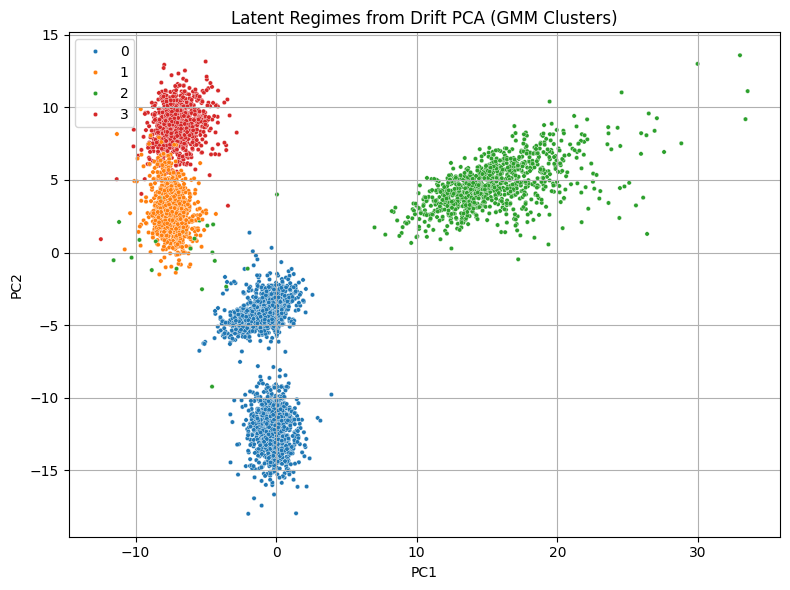

In [248]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)


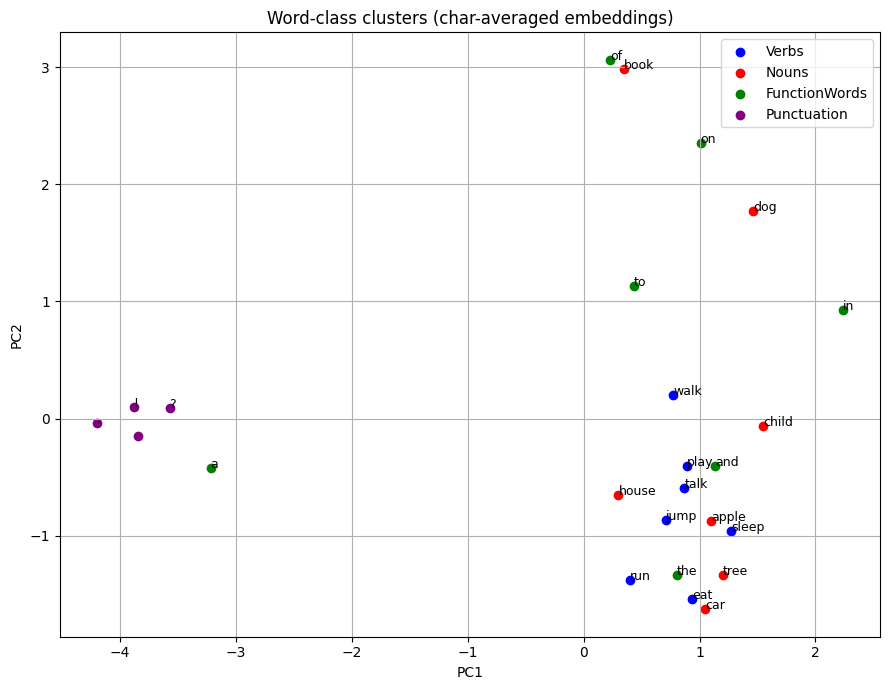

In [145]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.transformer.wte(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [258]:
file_path = 'simple_model.pth'

# 3. Save the model's state_dict
torch.save(model.state_dict(), file_path)